# Runtime tests

I worked out several runtime improvements for the calculation of observing windows. For each sequential improvement I ran timing tests with a small field grid setup (1056 Northern fields, 517 Southern fields). Each test was repeated four times.

In [29]:
import numpy as np
import pandas as pd
import seaborn as sns

## Load results

The tests correspond to the following code versions:

- t0: Code before runtime improvements.
- t1: Batch writing of observing windows to database.
- t2: Constraint calculation improvement (removed unnecessary calculations of further constraints, when it was already known that a source is not visible at a certain time due to previously calculated constraints).
- t3: Restructuring code order which removed many redundant calculations and parallelization. The tag suffixes `-x` refer to the number of cores used for the calculation, e.g. `t3-1` just used a single core for the observing window calculation.
- t4: MoonDistance constraint improvement (refinement calculations do not overwrite the saved frame and Moon positions, which avoids recalculation for all fields). The tag suffixes `-x` are the same as in test `t3`.

Note that each test is running for the incremental code versions. I.e. each code version includes all previous improvements.

In [32]:
tests = pd.read_csv('runtime_tests.dat', names=('test', 'id', 'runtime (days)'))
tests['runtime (min)'] = tests['runtime (days)'] * 24 * 60
tests

,test,id,runtime (days),runtime (min)
0,t0,0.000000,0.010474,15.083117
1,t0,1.000000,0.010393,14.966165
2,t0,2.000000,0.010440,15.033928
3,t0,3.000000,0.010291,14.819333
4,t1,0.000000,0.009588,13.807204
5,t1,1.000000,0.009590,13.808921
6,t1,2.000000,0.009584,13.801473
7,t1,3.000000,0.009589,13.808802
8,t2,0.000000,0.008539,12.296768
9,t2,1.000000,0.008528,12.279934


Group by code version and calculate the median runtime. Then calculate the fractional runtime relative to the initial code version and relative to the previous code version, similarly the runtime reduction:

In [38]:
tests_median = tests.drop(columns='id').groupby(by='test').median().reset_index()
tests_median['fraction_v0'] = tests_median['runtime (min)'] / tests_median.loc[0, 'runtime (min)']
tests_median['reduction_v0'] = 1 - tests_median['fraction_v0']
tests_median['fraction_incr'] = [np.nan] + [tests_median.loc[i, 'runtime (min)'] / tests_median.loc[i-1, 'runtime (min)'] for i in range(1, tests_median.shape[0])]
# manual fix to compare v4-1 with v3-1 and not v3-6:
tests_median.at[7, 'fraction_incr'] = tests_median.at[7, 'runtime (min)'] / tests_median.at[3, 'runtime (min)']
tests_median['reduction_incr'] = 1 - tests_median['fraction_incr']
tests_median

,test,runtime (days),runtime (min),fraction_v0,reduction_v0,fraction_incr,reduction_incr
0,t0,0.010417,15.000046,1.000000,0.000000,NaN,NaN
1,t1,0.009589,13.808003,0.920531,0.079469,0.920531,0.079469
2,t2,0.008540,12.297566,0.819835,0.180165,0.890611,0.109389
3,t3-1,0.005031,7.245113,0.483006,0.516994,0.589150,0.410850
4,t3-2,0.002908,4.187724,0.279181,0.720819,0.578007,0.421993
5,t3-4,0.001776,2.557346,0.170489,0.829511,0.610677,0.389323
6,t3-6,0.001564,2.252854,0.150190,0.849810,0.880934,0.119066
7,t4-1,0.003918,5.642088,0.376138,0.623862,0.778744,0.221256
8,t4-2,0.002335,3.361748,0.224116,0.775884,0.595834,0.404166
9,t4-4,0.001452,2.090697,0.139379,0.860621,0.621908,0.378092


## Show results

### Runtime

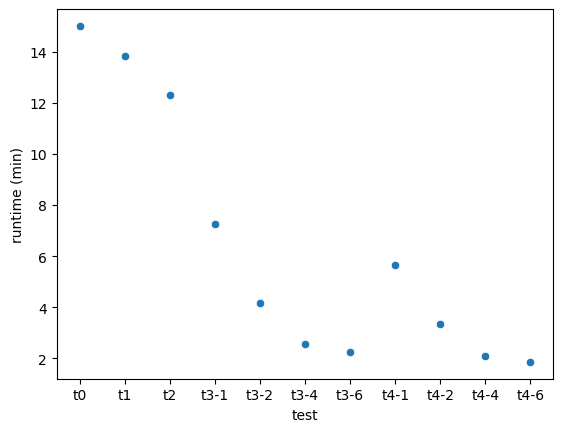

In [ ]:
sns.scatterplot(data=tests_median, x='test', y='runtime (min)');

### Fractional runtime relative to initial version

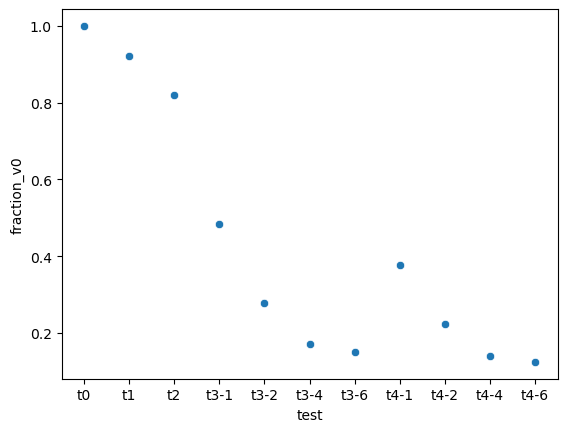

In [40]:
sns.scatterplot(data=tests_median, x='test', y='fraction_v0');

### Fractional runtime reduction relative to initial version

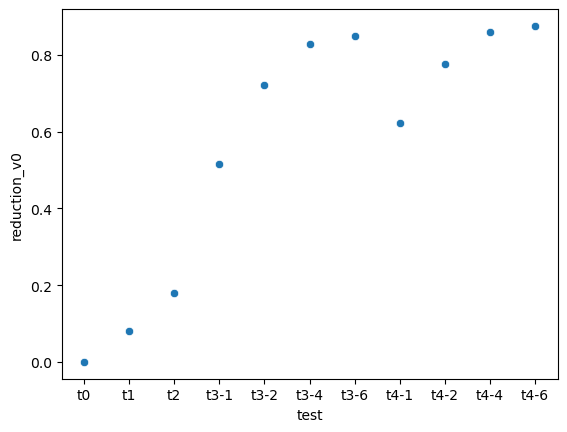

In [43]:
sns.scatterplot(data=tests_median, x='test', y='reduction_v0');

### Fractional runtime reduction relative to previous version

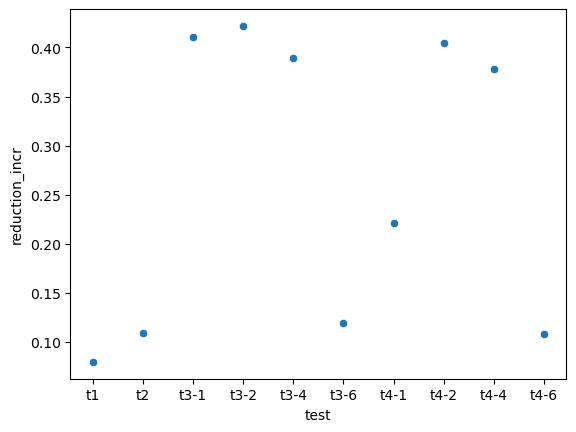

In [42]:
sns.scatterplot(data=tests_median, x='test', y='reduction_incr');

## Notes

* Each revision resulted in a substantial reduction of the runtime. Most productive were the removal of redundant repetitions as part of the parallelization (v2 to v3) and avoiding the recalculation of the Moon position (v3 to v4).
* Moving from 1 to 2 processes had the biggest impact.
* Adding more processes decreases the runtime, but the relative improvement becomes smaller with every process added. However, this is likely system dependent. I ran these tests on the institute's laptop which has 6 cores. I guess that the OS managing the processes cuts away substantial resources, which is why the incremental improvements become smaller. On a cluster the improvement may be much stronger and I need to test this once I get access, before I run the code on the actual field grid setup.